In [31]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

Hyperparameters

In [32]:
input_size = 3  # Number of input features
hidden_size = 50  # Number of LSTM units
output_size = 1  # Number of output features
num_layers = 2  # Number of LSTM layers
num_epochs = 100
learning_rate = 0.001
sequence_length = 10
batch_size = 32

directional = True # will only train on pucks moving in the correct direction

Dataset

In [33]:
def create_sequences(x, y, seq_length):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    y = torch.mul(y,1000)
    sequences = []
    labels = []

    for i in range(len(x) - seq_length):
        if x[i+seq_length][2] != -1: # if direction != left
            continue

        seq = x[i:i+seq_length]
        label = y[i+seq_length]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)


Data Loader

In [34]:
df = pd.read_csv("Data/cleaned_data.csv")
X = df[["Puck_cen_X","Puck_cen_Y","direction"]].values # values between 2 and -1
Y = df[["Cross_Left"]].values
#Y = df["Cross_right"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_sequences, train_labels = create_sequences(X_train, y_train, sequence_length)
test_sequences, test_labels = create_sequences(X_test, y_test, sequence_length)


LSTM Model

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

Criterion

In [36]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training

In [37]:
for epoch in range(num_epochs):
    outputs = model(train_sequences)
    loss = criterion(outputs, train_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 380677.3750
Epoch [20/100], Loss: 380164.1562
Epoch [30/100], Loss: 378526.3750
Epoch [40/100], Loss: 376800.4375
Epoch [50/100], Loss: 375563.4062
Epoch [60/100], Loss: 374654.5938
Epoch [70/100], Loss: 373861.9688
Epoch [80/100], Loss: 373111.4062
Epoch [90/100], Loss: 372402.0938
Epoch [100/100], Loss: 371721.1562


Testing

In [29]:
model.eval()
mseLoss = nn.MSELoss()
maeLoss = nn.L1Loss()
with torch.no_grad():
    test_outputs = model(test_sequences)
    mse = mseLoss(test_outputs, test_labels)
    mae = maeLoss(test_outputs, test_labels)
    print(f'Mean Square Error on Test Data: {mse.item():.4f}')
    print(f'Mean Absolute Error on Test Data: {mae.item():.4f}')

Mean Square Error on Test Data: 318072.6875
Mean Absolute Error on Test Data: 478.6214


Visualization

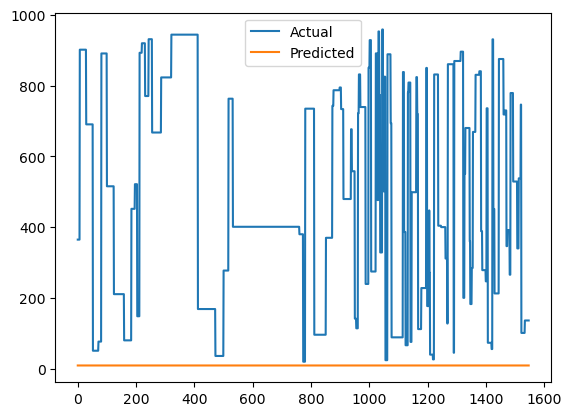

In [30]:
plt.plot(test_labels.numpy(), label='Actual')
plt.plot(test_outputs.numpy(), label='Predicted')
plt.legend()
plt.show()